# Imports

In [1]:
import csv
import itertools
import operator
import numpy as np
import nltk
import sys
from datetime import datetime

import matplotlib.pyplot as plt

import numpy as np
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn-white')
import re
from random import uniform

# Load 3 Text Books and Concatenate

In [2]:
#text files concatenation 
filenames = ['A_Journey_to_the_Center_of_the_Earth.txt', 'From_the_Earth_to_the_Moon.txt', 'The_master_of_the_world.txt']
with open('/Users/pprusty05/google_drive/Deep_Learning/assignment3/Text_file_for_training.txt', 'w+') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                outfile.write(line)

# Preprocess data

In [3]:
train_data = open('Text_file_for_training.txt', 'r').read() 
train_data = [re.sub('[^a-zA-Z0-9]', ' ', x)for x in train_data]
train_data = [char.lower() for char in train_data]

chars = list(set(train_data))
data_size,char_size = len(train_data), len(chars)
print("data has %d characters, %d unique" %(data_size, char_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }


data has 1336569 characters, 37 unique


In [4]:
ix_to_char

{0: ' ',
 1: 'j',
 2: 't',
 3: '9',
 4: '6',
 5: 'g',
 6: '8',
 7: 'w',
 8: 'c',
 9: '4',
 10: 'l',
 11: 'q',
 12: 'a',
 13: 'k',
 14: '3',
 15: 'i',
 16: 'z',
 17: '1',
 18: 'f',
 19: 'u',
 20: 's',
 21: '7',
 22: 'o',
 23: 'b',
 24: 'r',
 25: 'v',
 26: 'n',
 27: 'd',
 28: '0',
 29: 'y',
 30: 'm',
 31: '2',
 32: 'p',
 33: 'e',
 34: '5',
 35: 'h',
 36: 'x'}

# Task 2: Character level LSTM RNN

In [56]:
# Constants and hyper-params
H_size = 100 # Size of the hidden layer
T_steps = 100
# Number of time steps (length of the sequence) used for training
learning_rate = 1e-1 # Learning rate
weight_sd = 0.1 # Standard deviation of weights for initialization
z_size = H_size + char_size # Size of concatenate(H, X) vector

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def dsigmoid(y):
    return y * (1 - y)


def tanh(x):
    return np.tanh(x)


def dtanh(y):
    return 1 - y * y

In [7]:
# Parameters
# We use random weights with normal distribution (0, weight_sd) for  tanh  activation function 
# and (0.5, weight_sd) for  sigmoid  activation function.
# Biases are initialized to zeros.
class Param:
    def __init__(self, name, value):
        self.name = name
        self.v = value #parameter value
        self.d = np.zeros_like(value) #derivative
        self.m = np.zeros_like(value) #momentum for AdaGrad
        
class Parameters:
    def __init__(self):
        self.W_f = Param('W_f', 
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_f = Param('b_f',
                         np.zeros((H_size, 1)))

        self.W_i = Param('W_i',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_i = Param('b_i',
                         np.zeros((H_size, 1)))

        self.W_C = Param('W_C',
                         np.random.randn(H_size, z_size) * weight_sd)
        self.b_C = Param('b_C',
                         np.zeros((H_size, 1)))

        self.W_o = Param('W_o',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_o = Param('b_o',
                         np.zeros((H_size, 1)))

        #For final layer to predict the next character
        self.W_v = Param('W_v',
                         np.random.randn(char_size, H_size) * weight_sd)
        self.b_v = Param('b_v',
                         np.zeros((char_size, 1)))
        
    def all(self):
        return [self.W_f, self.W_i, self.W_C, self.W_o, self.W_v,
               self.b_f, self.b_i, self.b_C, self.b_o, self.b_v]
        
parameters = Parameters()

In [8]:
def forward(x, h_prev, C_prev, p = parameters):
    assert x.shape == (char_size, 1)
    assert h_prev.shape == (H_size, 1)
    assert C_prev.shape == (H_size, 1)
    
    z = np.row_stack((h_prev, x))
    f = sigmoid(np.dot(p.W_f.v, z) + p.b_f.v)
    i = sigmoid(np.dot(p.W_i.v, z) + p.b_i.v)
    C_bar = tanh(np.dot(p.W_C.v, z) + p.b_C.v)

    C = f * C_prev + i * C_bar
    o = sigmoid(np.dot(p.W_o.v, z) + p.b_o.v)
    h = o * tanh(C)

    v = np.dot(p.W_v.v, h) + p.b_v.v
    y = np.exp(v) / np.sum(np.exp(v)) #softmax

    return z, f, i, C_bar, C, o, h, v, y

In [9]:
dummyVector = np.random.randn(10, 1)

In [10]:
sigmoid(dummyVector)

array([[0.10843756],
       [0.27462731],
       [0.69422515],
       [0.25667208],
       [0.84022248],
       [0.41539372],
       [0.44102327],
       [0.81404577],
       [0.72268992],
       [0.7642361 ]])

In [11]:
def backward(target, dh_next, dC_next, C_prev,
             z, f, i, C_bar, C, o, h, v, y,
             p = parameters):
    
    assert z.shape == (char_size + H_size, 1)
    assert v.shape == (char_size, 1)
    assert y.shape == (char_size, 1)
    
    for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
        assert param.shape == (H_size, 1)
        
    dv = np.copy(y)
    dv[target] -= 1

    p.W_v.d += np.dot(dv, h.T)
    p.b_v.d += dv

    dh = np.dot(p.W_v.v.T, dv)        
    dh += dh_next
    do = dh * tanh(C)
    do = dsigmoid(o) * do
    p.W_o.d += np.dot(do, z.T)
    p.b_o.d += do

    dC = np.copy(dC_next)
    dC += dh * o * dtanh(tanh(C))
    dC_bar = dC * i
    dC_bar = dtanh(C_bar) * dC_bar
    p.W_C.d += np.dot(dC_bar, z.T)
    p.b_C.d += dC_bar

    di = dC * C_bar
    di = dsigmoid(i) * di
    p.W_i.d += np.dot(di, z.T)
    p.b_i.d += di

    df = dC * C_prev
    df = dsigmoid(f) * df
    p.W_f.d += np.dot(df, z.T)
    p.b_f.d += df

    dz = (np.dot(p.W_f.v.T, df)
         + np.dot(p.W_i.v.T, di)
         + np.dot(p.W_C.v.T, dC_bar)
         + np.dot(p.W_o.v.T, do))
    dh_prev = dz[:H_size, :]
    dC_prev = f * dC
    
    return dh_prev, dC_prev

In [12]:
# Clear gradients before each backward pass
def clear_gradients(params = parameters):
    for p in params.all():
        p.d.fill(0)

In [13]:
# Clip gradients to mitigate exploding gradients
def clip_gradients(params = parameters):
    for p in params.all():
        np.clip(p.d, -1, 1, out=p.d)

In [14]:
def forward_backward(inputs, targets, h_prev, C_prev):
    global paramters
    
    # To store the values for each time step
    x_s, z_s, f_s, i_s,  = {}, {}, {}, {}
    C_bar_s, C_s, o_s, h_s = {}, {}, {}, {}
    v_s, y_s =  {}, {}
    
    # Values at t - 1
    h_s[-1] = np.copy(h_prev)
    C_s[-1] = np.copy(C_prev)
    
    loss = 0
    # Loop through time steps
    assert len(inputs) == T_steps
    for t in range(len(inputs)):
        x_s[t] = np.zeros((char_size, 1))
        x_s[t][inputs[t]] = 1 # Input character
        
        (z_s[t], f_s[t], i_s[t],
        C_bar_s[t], C_s[t], o_s[t], h_s[t],
        v_s[t], y_s[t]) = \
            forward(x_s[t], h_s[t - 1], C_s[t - 1]) # Forward pass
       
            
        loss += -np.log(y_s[t][targets[t], 0]) # Loss for at t
        
    clear_gradients()

    dh_next = np.zeros_like(h_s[0]) #dh from the next character
    dC_next = np.zeros_like(C_s[0]) #dh from the next character

    for t in reversed(range(len(inputs))):
        # Backward pass
        dh_next, dC_next = \
            backward(target = targets[t], dh_next = dh_next,
                     dC_next = dC_next, C_prev = C_s[t-1],
                     z = z_s[t], f = f_s[t], i = i_s[t], C_bar = C_bar_s[t],
                     C = C_s[t], o = o_s[t], h = h_s[t], v = v_s[t],
                     y = y_s[t])

    clip_gradients()
        
    return loss, h_s[len(inputs) - 1], C_s[len(inputs) - 1]

In [15]:
def generate_next_char(h_prev, C_prev, first_char_idx, sentence_length):
    x = np.zeros((char_size, 1))
    x[first_char_idx] = 1

    h = h_prev
    C = C_prev

    indexes = []
    
    for t in range(sentence_length):
        _, _, _, _, C, _, h, _, p = forward(x, h, C)
        idx = np.random.choice(range(char_size), p=p.ravel())
        x = np.zeros((char_size, 1))
        x[idx] = 1
        indexes.append(idx)

    return indexes

In [16]:
# Update the graph and display a sample output
def update_status(inputs, h_prev, C_prev):
    #initialized later
    global plot_iter, plot_loss
    global smooth_loss
    
    # Get predictions for 200 letters with current model

    sample_idx = generate_next_char(h_prev, C_prev, inputs[0], 200)
    txt = ''.join(ix_to_char[idx] for idx in sample_idx)

    # Clear and plot
    plt.plot(plot_iter, plot_loss)
    display.clear_output(wait=True)
    plt.show()

    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))
    print("iter %d, loss %f" % (iteration, smooth_loss))

In [17]:
def update_paramters(params = parameters):
    for p in params.all():
        p.m += p.d * p.d # Calculate sum of gradients
        #print(learning_rate * dparam)
        p.v += -(learning_rate * p.d / np.sqrt(p.m + 1e-8))

In [18]:
# To delay the keyboard interrupt to prevent the training from stopping in the middle of an iteration
import signal

class DelayedKeyboardInterrupt(object):
    def __enter__(self):
        self.signal_received = False
        self.old_handler = signal.signal(signal.SIGINT, self.handler)

    def handler(self, sig, frame):
        self.signal_received = (sig, frame)
        print('SIGINT received. Delaying KeyboardInterrupt.')

    def __exit__(self, type, value, traceback):
        signal.signal(signal.SIGINT, self.old_handler)
        if self.signal_received:
            self.old_handler(*self.signal_received)

In [19]:
# Exponential average of loss
# Initialize to a error of a random model
smooth_loss = -np.log(1.0 / char_size) * T_steps

iteration, pointer = 0, 0

# For the graph
plot_iter = np.zeros((0))
plot_loss = np.zeros((0))

In [24]:
len(train_data)

1336569

In [39]:
# Update the graph and display a sample output
def print_status(inputs, h_prev, C_prev):
    # Get predictions for 200 letters with current model
    sample_idx = generate_next_char(h_prev, C_prev, inputs[0], 200)
    txt = ''.join(ix_to_char[idx] for idx in sample_idx)
    # Clear and plot
    #plt.plot(plot_iter, plot_loss)
    #display.clear_output(wait=True)
    #plt.show()
    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))

prediction at breakpoint:  10
----
 w  chapter 22 a  and wlarral    michavioat 1guned it   jute rearnes  chapter 36 o claffer any wnlerang  charter  of benow by the trinulic  a  then july  the waysing prowouncthing propidintless siffees 
----
prediction at breakpoint:  20
----
 s byctispishing  and worms  chanter 28 lost  chapter 2212 jelves  mignt  chapter 26 thore of juce on durac to gutenbis gutenberg the wessel quapters is verned upepormcrr by temee an journ out centulis 
----
prediction at breakpoint:  30
----
 d to the centred  apporbhe  a bedture sunderor acflark roff  andmeding  chapter 23 t2x b conterion out earazer  the sabm occart on the hunbeing  chapter 33 atrown anderthing on shanderger   chapter 19 
----
prediction at breakpoint:  40
----
  al uzbont gunenbe  10    the eider and not and dentingules  by jute of commed become  the project ounment  jume of the adrents on projecve  gitengen  a lestork it is woteriaginal attratter 3 griod co 
----
prediction at breakpoint:  5

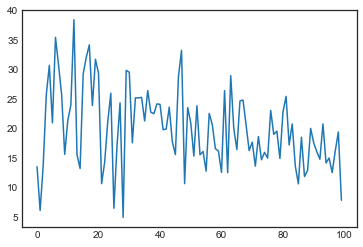

In [51]:
list_of_breakpoints = [10,20,30,40,50,60,70,80,99]
iteration=0
plot_loss_inner = []
for i in range(100):
    if pointer + T_steps >= len(train_data) or iteration == 0:
        g_h_prev = np.zeros((H_size, 1))
        g_C_prev = np.zeros((H_size, 1))
        pointer = 0
    inputs = ([char_to_ix[ch] 
               for ch in train_data[pointer: pointer + T_steps]])
    targets = ([char_to_ix[ch] 
                for ch in train_data[pointer + 1: pointer + T_steps + 1]])


    loss, g_h_prev, g_C_prev = \
        forward_backward(inputs, targets, g_h_prev, g_C_prev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if iteration in list_of_breakpoints:
        print('prediction at breakpoint: ', iteration)
        print_status(inputs, g_h_prev, g_C_prev)

    update_paramters()
    plot_loss_inner = np.append(plot_loss_inner, [loss])

    pointer += T_steps
    iteration += 1

plt.plot(plot_loss_inner)


        

In [60]:
class Char_LSTM:
    
    def __init__(self, name, value):
        self.name = name
        self.v = value #parameter value
        self.d = np.zeros_like(value) #derivative
        self.m = np.zeros_like(value) #momentum for AdaGrad
        
    
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))


    def dsigmoid(self,y):
        return y * (1 - y)


    def tanh(self,x):
        return np.tanh(x)


    def dtanh(self,y):
        return 1 - y * y

   
    def __init__(self):
        self.W_f = Param('W_f', 
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_f = Param('b_f',
                         np.zeros((H_size, 1)))

        self.W_i = Param('W_i',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_i = Param('b_i',
                         np.zeros((H_size, 1)))

        self.W_C = Param('W_C',
                         np.random.randn(H_size, z_size) * weight_sd)
        self.b_C = Param('b_C',
                         np.zeros((H_size, 1)))

        self.W_o = Param('W_o',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_o = Param('b_o',
                         np.zeros((H_size, 1)))

        #For final layer to predict the next character
        self.W_v = Param('W_v',
                         np.random.randn(char_size, H_size) * weight_sd)
        self.b_v = Param('b_v',
                         np.zeros((char_size, 1)))
        
    def all(self):
        return [self.W_f, self.W_i, self.W_C, self.W_o, self.W_v,
               self.b_f, self.b_i, self.b_C, self.b_o, self.b_v]
        
        
    def forward(self,x, h_prev, C_prev, p = parameters):
        assert x.shape == (char_size, 1)
        assert h_prev.shape == (H_size, 1)
        assert C_prev.shape == (H_size, 1)

        z = np.row_stack((h_prev, x))
        f = self.sigmoid(np.dot(p.W_f.v, z) + p.b_f.v)
        i = self.sigmoid(np.dot(p.W_i.v, z) + p.b_i.v)
        C_bar = self.tanh(np.dot(p.W_C.v, z) + p.b_C.v)

        C = f * C_prev + i * C_bar
        o = self.sigmoid(np.dot(p.W_o.v, z) + p.b_o.v)
        h = o * self.tanh(C)

        v = np.dot(p.W_v.v, h) + p.b_v.v
        y = np.exp(v) / np.sum(np.exp(v)) #softmax

        return z, f, i, C_bar, C, o, h, v, y
    
    def backward(self,target, dh_next, dC_next, C_prev,
             z, f, i, C_bar, C, o, h, v, y,
             p = parameters):
    
        assert z.shape == (char_size + H_size, 1)
        assert v.shape == (char_size, 1)
        assert y.shape == (char_size, 1)

        for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
            assert param.shape == (H_size, 1)

            dv = np.copy(y)
            dv[target] -= 1

            p.W_v.d += np.dot(dv, h.T)
            p.b_v.d += dv

            dh = np.dot(p.W_v.v.T, dv)        
            dh += dh_next
            do = dh * tanh(C)
            do = self.dsigmoid(o) * do
            p.W_o.d += np.dot(do, z.T)
            p.b_o.d += do

            dC = np.copy(dC_next)
            dC += dh * o * dtanh(tanh(C))
            dC_bar = dC * i
            dC_bar = self.dtanh(C_bar) * dC_bar
            p.W_C.d += np.dot(dC_bar, z.T)
            p.b_C.d += dC_bar

            di = dC * C_bar
            di = self.dsigmoid(i) * di
            p.W_i.d += np.dot(di, z.T)
            p.b_i.d += di

            df = dC * C_prev
            df = self.dsigmoid(f) * df
            p.W_f.d += np.dot(df, z.T)
            p.b_f.d += df

            dz = (np.dot(p.W_f.v.T, df)
                 + np.dot(p.W_i.v.T, di)
                 + np.dot(p.W_C.v.T, dC_bar)
                 + np.dot(p.W_o.v.T, do))
            dh_prev = dz[:H_size, :]
            dC_prev = f * dC

            return dh_prev, dC_prev

    def clear_gradients(self,params = parameters):
        for p in params.all():
            p.d.fill(0)
            
    def clip_gradients(self,params = parameters):
        for p in params.all():
            np.clip(p.d, -1, 1, out=p.d)
            
    def forward_backward(self,inputs, targets, h_prev, C_prev):
        global paramters

        # To store the values for each time step
        x_s, z_s, f_s, i_s,  = {}, {}, {}, {}
        C_bar_s, C_s, o_s, h_s = {}, {}, {}, {}
        v_s, y_s =  {}, {}

        # Values at t - 1
        h_s[-1] = np.copy(h_prev)
        C_s[-1] = np.copy(C_prev)

        loss = 0
        # Loop through time steps
        assert len(inputs) == T_steps
        for t in range(len(inputs)):
            x_s[t] = np.zeros((char_size, 1))
            x_s[t][inputs[t]] = 1 # Input character

            (z_s[t], f_s[t], i_s[t],
            C_bar_s[t], C_s[t], o_s[t], h_s[t],
            v_s[t], y_s[t]) = \
                self.forward(x_s[t], h_s[t - 1], C_s[t - 1]) # Forward pass


            loss += -np.log(y_s[t][targets[t], 0]) # Loss for at t

        clear_gradients()

        dh_next = np.zeros_like(h_s[0]) #dh from the next character
        dC_next = np.zeros_like(C_s[0]) #dh from the next character

        for t in reversed(range(len(inputs))):
            # Backward pass
            dh_next, dC_next = \
                self.backward(target = targets[t], dh_next = dh_next,
                         dC_next = dC_next, C_prev = C_s[t-1],
                         z = z_s[t], f = f_s[t], i = i_s[t], C_bar = C_bar_s[t],
                         C = C_s[t], o = o_s[t], h = h_s[t], v = v_s[t],
                         y = y_s[t])

        clip_gradients()

        return loss, h_s[len(inputs) - 1], C_s[len(inputs) - 1]
    
    def generate_next_char(self,h_prev, C_prev, first_char_idx, sentence_length):
        x = np.zeros((char_size, 1))
        x[first_char_idx] = 1

        h = h_prev
        C = C_prev

        indexes = []

        for t in range(sentence_length):
            _, _, _, _, C, _, h, _, p = self.forward(x, h, C)
            idx = np.random.choice(range(char_size), p=p.ravel())
            x = np.zeros((char_size, 1))
            x[idx] = 1
            indexes.append(idx)

        return indexes
    
    def update_status(inputs, h_prev, C_prev):
        #initialized later
        global plot_iter, plot_loss
        global smooth_loss

        # Get predictions for 200 letters with current model

        sample_idx = self.generate_next_char(h_prev, C_prev, inputs[0], 200)
        txt = ''.join(ix_to_char[idx] for idx in sample_idx)

        # Clear and plot
        plt.plot(plot_iter, plot_loss)
        display.clear_output(wait=True)
        plt.show()

        #Print prediction and loss
        print("----\n %s \n----" % (txt, ))
        print("iter %d, loss %f" % (iteration, smooth_loss))
        
    def update_paramters(params = parameters):
        for p in params.all():
            p.m += p.d * p.d # Calculate sum of gradients
            #print(learning_rate * dparam)
            p.v += -(learning_rate * p.d / np.sqrt(p.m + 1e-8))
            
            # To delay the keyboard interrupt to prevent the training from stopping in the middle of an iteration
    import signal

    

In [ ]:
class DelayedKeyboardInterrupt(object):
    def __enter__(self):
        self.signal_received = False
        self.old_handler = signal.signal(signal.SIGINT, self.handler)

    def handler(self, sig, frame):
        self.signal_received = (sig, frame)
        print('SIGINT received. Delaying KeyboardInterrupt.')

    def __exit__(self, type, value, traceback):
        signal.signal(signal.SIGINT, self.old_handler)
        if self.signal_received:
            self.old_handler(*self.signal_received)


In [ ]:
# Exponential average of loss
# Initialize to a error of a random model
smooth_loss = -np.log(1.0 / char_size) * T_steps

iteration, pointer = 0, 0

# For the graph
plot_iter = np.zeros((0))
plot_loss = np.zeros((0))

In [ ]:
# Update the graph and display a sample output
def print_status(inputs, h_prev, C_prev):
    # Get predictions for 200 letters with current model
    sample_idx = generate_next_char(h_prev, C_prev, inputs[0], 200)
    txt = ''.join(ix_to_char[idx] for idx in sample_idx)
    # Clear and plot
    #plt.plot(plot_iter, plot_loss)
    #display.clear_output(wait=True)
    #plt.show()
    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))

prediction at breakpoint:  10
----
 bor oun boted should exidestrishon at the  cortions  a sentestive  chapter nim no liles doajing with tome chapter 5 digraved  chapting combamine  i  come deporfats chaps  2865 of centering  chapter 29 
----
prediction at breakpoint:  20
----
 ur boit  delosth is scamiding was project a langer hand mount scrate of the am sed answoliking  thingey it a complouds and blleated to exelt silefi anter grownter  then you men  subchended of i contib 
----
prediction at breakpoint:  30
----
  wish alforit  then icho gutenbest we weres wat our falleng of fartere in excedtroy  the contermeng  the project despones to periot  chaptern8 and twly were on journey first wriccims only start  wathe 
----
prediction at breakpoint:  40
----
  verviliok  chapter 34 we coverit  unded       chapter 14 the nactlit mepering of mabes and tenteried    restinules  chapter 23 our doutt at aftated rustering  chapter 4 any going  chapter 32 the vail 
----
prediction at breakpoint:  5

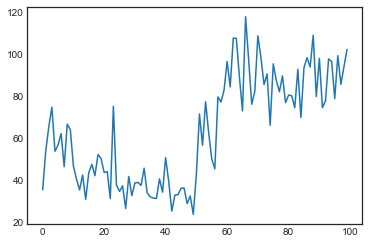

In [63]:
CLSTM=Char_LSTM()
list_of_breakpoints = [10,20,30,40,50,60,70,80,99]
iteration=0
plot_loss_inner = []
T_steps=50
for i in range(100):
    if pointer + T_steps >= len(train_data) or iteration == 0:
        g_h_prev = np.zeros((H_size, 1))
        g_C_prev = np.zeros((H_size, 1))
        pointer = 0
    inputs = ([char_to_ix[ch] 
               for ch in train_data[pointer: pointer + T_steps]])
    targets = ([char_to_ix[ch] 
                for ch in train_data[pointer + 1: pointer + T_steps + 1]])


    loss, g_h_prev, g_C_prev = \
        CLSTM.forward_backward(inputs, targets, g_h_prev, g_C_prev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if iteration in list_of_breakpoints:
        print('prediction at breakpoint: ', iteration)
        print_status(inputs, g_h_prev, g_C_prev)

    update_paramters()
    plot_loss_inner = np.append(plot_loss_inner, [loss])

    pointer += T_steps
    iteration += 1

plt.plot(plot_loss_inner)


        

In [58]:
T_steps_half

50.0

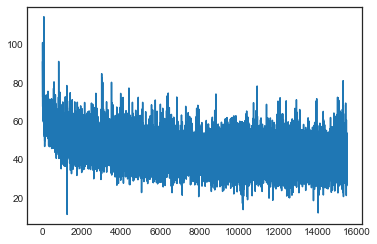

----
 puterest and steateenness unter to commical xiken and a minuted with this marmens an preeged was to had the ass bremesion  ploanting the peet possificued  if my armo importion over nons  my uncle or n 
----
iter 15495, loss 41.161714


In [29]:
while True:
    try:
        with DelayedKeyboardInterrupt():
            # Reset
            if pointer + T_steps >= len(train_data) or iteration == 0:
                g_h_prev = np.zeros((H_size, 1))
                g_C_prev = np.zeros((H_size, 1))
                pointer = 0


            inputs = ([char_to_ix[ch] 
                       for ch in train_data[pointer: pointer + T_steps]])
            targets = ([char_to_ix[ch] 
                        for ch in train_data[pointer + 1: pointer + T_steps + 1]])
            

            loss, g_h_prev, g_C_prev = \
                forward_backward(inputs, targets, g_h_prev, g_C_prev)
            smooth_loss = smooth_loss * 0.999 + loss * 0.001

            # Print every hundred steps
            if iteration % 100 == 0:
                update_status(inputs, g_h_prev, g_C_prev)

            update_paramters()

            plot_iter = np.append(plot_iter, [iteration])
            plot_loss = np.append(plot_loss, [loss])

            pointer += T_steps
            iteration += 1
    except KeyboardInterrupt:
        update_status(inputs, g_h_prev, g_C_prev)
        break

In [21]:


# Calculate numerical gradient
def calc_numerical_gradient(param, idx, delta, inputs, target, h_prev, C_prev):
    old_val = param.v.flat[idx]
    
    # evaluate loss at [x + delta] and [x - delta]
    param.v.flat[idx] = old_val + delta
    loss_plus_delta, _, _ = forward_backward(inputs, targets,
                                             h_prev, C_prev)
    param.v.flat[idx] = old_val - delta
    loss_mins_delta, _, _ = forward_backward(inputs, targets, 
                                             h_prev, C_prev)
    
    param.v.flat[idx] = old_val #reset

    grad_numerical = (loss_plus_delta - loss_mins_delta) / (2 * delta)
    # Clip numerical error because analytical gradient is clipped
    [grad_numerical] = np.clip([grad_numerical], -1, 1) 
    
    return grad_numerical

In [22]:
# Check gradient of each paramter matrix/vector at `num_checks` individual values
def gradient_check(num_checks, delta, inputs, target, h_prev, C_prev):
    global parameters
    
    # To calculate computed gradients
    _, _, _ =  forward_backward(inputs, targets, h_prev, C_prev)
    
    
    for param in parameters.all():
        #Make a copy because this will get modified
        d_copy = np.copy(param.d)

        # Test num_checks times
        for i in range(num_checks):
            # Pick a random index
            rnd_idx = int(uniform(0, param.v.size))
            
            grad_numerical = calc_numerical_gradient(param,
                                                     rnd_idx,
                                                     delta,
                                                     inputs,
                                                     target,
                                                     h_prev, C_prev)
            grad_analytical = d_copy.flat[rnd_idx]

            err_sum = abs(grad_numerical + grad_analytical) + 1e-09
            rel_error = abs(grad_analytical - grad_numerical) / err_sum
            
            # If relative error is greater than 1e-06
            if rel_error > 1e-06:
                print('%s (%e, %e) => %e'
                      % (param.name, grad_numerical, grad_analytical, rel_error))

In [23]:
gradient_check(10, 1e-5, inputs, targets, g_h_prev, g_C_prev)

W_v (8.099370e-05, 8.099340e-05) => 1.830691e-06
W_v (9.556409e-05, 9.556513e-05) => 5.446902e-06
b_o (2.953575e-02, 2.953583e-02) => 1.411764e-06
b_o (5.507841e-02, 5.507869e-02) => 2.541917e-06
b_o (3.957211e-02, 3.957177e-02) => 4.368174e-06
